In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%aimport common_utils
%aimport torch_importance_sampling_tr
%autoreload 1

In [4]:
%aimport torch_importance_sampling_tr
%autoreload 1
from torch_importance_sampling_tr import VarReductionCondition, get_g
from common_utils import Accumulator

def train_batch_is(model,
                batch,  
                loss_fn, 
                optimizer, 
                accumulator : Accumulator,
                condition : VarReductionCondition, 
                presample = 3.0, 
                use_loss_estimation = False,
                second_approach = False):

    flag = False
    model.train()
    model.zero_grad()

    (X_batch, y_batch) = batch
    batch_size = X_batch.shape[0]
    no_grad_y_batch = y_batch
    selected_batch_size = int(batch_size / presample)
    
    if condition.satisfied :
        #print("condition satisfied")
        if second_approach:
            with torch.no_grad(): no_grad_output = model(X_batch)
            g_i_norm = get_g(no_grad_output, y_batch, loss_fn, use_loss_estimation)
        else :
            output = model(X_batch)
            g_i_norm = get_g(output, y_batch, loss_fn, use_loss_estimation)

        condition.update(g_i_norm)
        flag = True
    else:
        #print("condition not satisfied")
        g_i_norm = np.ones(batch_size)


    p_i = g_i_norm / np.sum(g_i_norm)
    batch_indices = np.random.choice(np.arange(batch_size), size = selected_batch_size, replace=True, p=p_i)

    selected_p_i = p_i[batch_indices]

    if condition.previously_satisfied:
        if second_approach:
            output = model(X_batch[batch_indices])
            y_batch = y_batch[batch_indices]
            loss = loss_fn(output, y_batch)
            selected_loss = loss
        else:
            loss = loss_fn(output, y_batch)
            selected_loss = loss[batch_indices]
    else :
        output = model(X_batch[batch_indices])
        y_batch = y_batch[batch_indices]
        condition.update( get_g(output, y_batch, loss_fn, use_loss_estimation) )
        loss = loss_fn(output, y_batch)
        selected_loss = loss
        
    w_i = 1.0 / (batch_size * selected_p_i)

    weighted_loss = (torch.tensor(w_i).to(selected_loss.device).detach() * selected_loss).mean()

    weighted_loss.backward()

    optimizer.step()
    
    max_p_i = np.max(p_i)
    num_unique_points = np.unique(batch_indices).size


    n = len(output)
    with torch.no_grad():
        if second_approach:
            output = no_grad_output
            y_batch = no_grad_y_batch
            loss = loss_fn(output, y_batch)
            
        batch_loss = loss.mean().cpu().item()
        weighted_batch_loss = weighted_loss.mean().cpu().item()
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()/n

    
    accumulator.average( 
        train_loss = ( batch_loss, n) ,
        train_acc = ( batch_acc_sum, n) ,
        train_w_loss = ( weighted_batch_loss, selected_batch_size) ,
        train_uniform_cnt = flag)
    
    accumulator.store( 
        max_p_i = max_p_i ,
        num_unique_points = num_unique_points)


In [5]:
def train_full(model, 
               train_dataloader, 
               loss_fn, 
               optimizer, 
               n_epochs, 
               eval = None, 
               callback=None, 
               presample=2, 
               tau_th = None, 
               use_loss_estimation = False,
               **kwargs ):
    

    large_batch = int( train_dataloader.batch_size)

    # Compute the threshold using eq. 29 in
    # https://arxiv.org/abs/1803.00942

    B = large_batch
    b = int( large_batch / presample)
    tau_th = float(B + 3*b) / (3*b) if tau_th is None else   tau_th

    condition = VarReductionCondition(tau_th)
    
    if callback :
        callback.setMeta(
            large_batch = large_batch,
            n_epochs = n_epochs, 
            presample = presample, 
            tau_th = tau_th,
            use_loss_estimation = use_loss_estimation)

    epochs = tqdm(range(n_epochs), desc='Epochs', leave=True)
    for i_epoch in epochs:
        accum = Accumulator()
        
        for X_batch, y_batch in train_dataloader:
            train_batch_is( model, 
                            (X_batch.to(model.device), y_batch.to(model.device)),
                            loss_fn, 
                            optimizer, 
                            accum,
                            condition,
                            presample,
                            use_loss_estimation,
                            **kwargs)
            
        if callback :
            val_scores = eval(model) if eval else {}
            #print(condition.string + f" n_un={callback.n_un[-1]}")
            cb_dict = callback( **accum.getAll(), **val_scores)
            print(condition.string)
            epochs.set_postfix(cb_dict)
            

In [6]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch.to(model.device)).cpu()
            logits.append(output)
            targets.append(y_batch)
    logits = torch.cat(logits)
    targets = torch.cat(targets)
    loss = loss_fn(logits, targets).mean().item()
    acc = (logits.argmax(dim=1) == targets).sum().item() / len(targets)
    return loss, acc

In [7]:
from data_loaders import train_val_dataloader, test_dataloader
train_dataloader, val_dataloader = train_val_dataloader(batch_size=120)#128*3
test_loader = test_dataloader(batch_size=120)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
%autoreload 1
from models import ResNet50
from common_utils import UnCallBack

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
model = ResNet50()
model.to(device)
model.device = device

loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'train_w_loss', 'val_loss', 'val_acc', 'train_uniform_cnt'])

def eval_callback(model):
    loss, acc =evaluate(model, val_dataloader, loss_fn)
    return {"val_loss": loss, "val_acc": acc}


train_full( model, 
            train_dataloader, 
            loss_fn, 
            optimizer, 
            n_epochs = 50, 
            eval = eval_callback, 
            callback = callback, 
            presample = 3, 
            tau_th = -0.1,
            use_loss_estimation = False,
            second_approach = True)
#142.20s
callback.save("loss_estimation")

In [ ]:

loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ResNet50, test loss: {loss}')
print(f'ResNet50, test accuracy: {acc}')

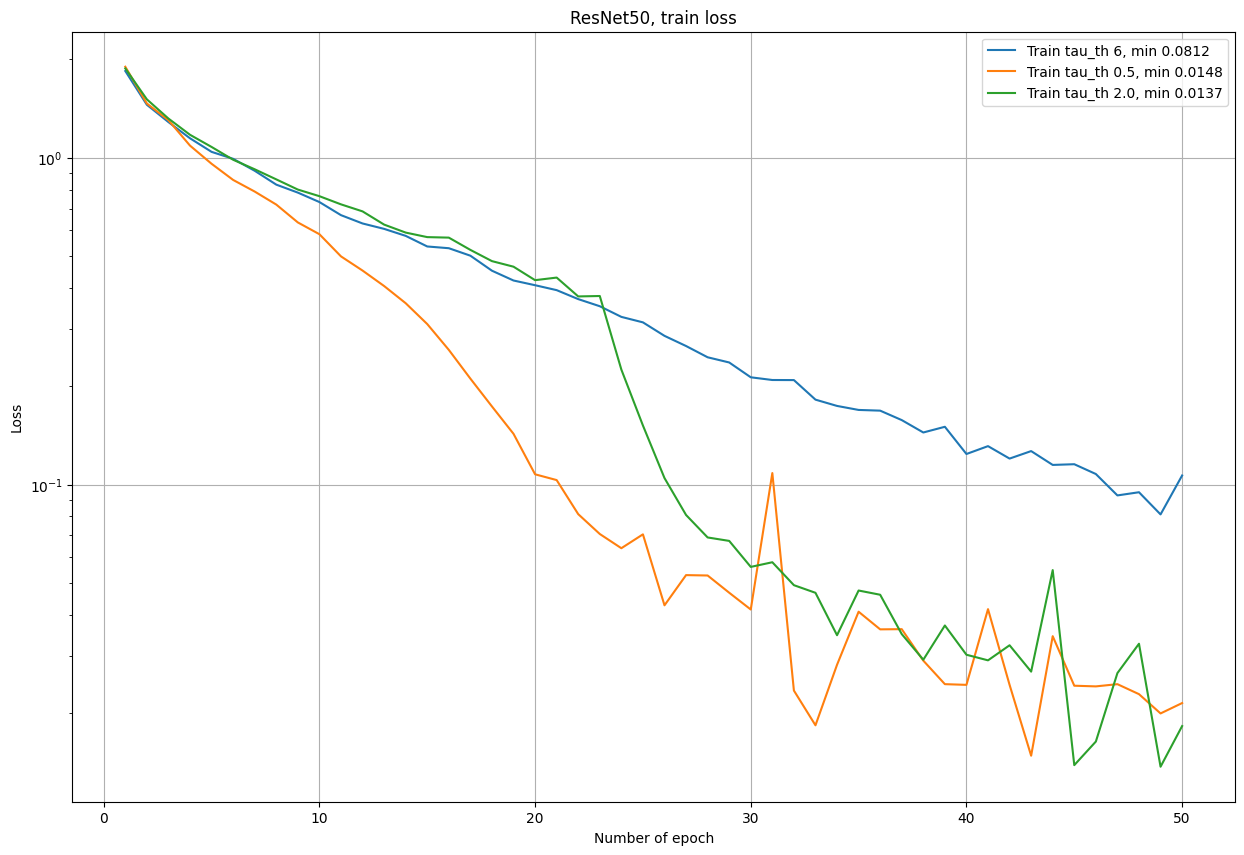

In [21]:
from common_utils import UnCallBack
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
callback_1= UnCallBack.load("callbacks/callback.pickle")
callback_2= UnCallBack.load("callbacks/callback_0.pickle")
callback_3= UnCallBack.load("callbacks/callback_total.pickle")
callback_4= UnCallBack.load("callbacks/rho_loss.pickle")

plt.figure(figsize=(15, 10))
plt.title('ResNet50, train loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')


def smoth(x,N_ = 5):
    return np.convolve([1.0/N_]*N_,x,"valid")

cllbacks = [callback_1, callback_2, callback_3]

length = min( len(i.train_loss) for i in cllbacks)

for callback in [callback_1, callback_2, callback_3]:
    suffix = f'tau_th {callback.meta["tau_th"]}'

    min_loss = min(callback.train_loss[0:length])
    y = smoth(callback.train_loss[0:length],1)
    epochs = np.arange(length) + 1
    plt.plot(epochs, y , label=f'Train {suffix}, min {min_loss:.4f}')
    #plt.plot(epochs, callback.train_w_loss , label='Train weighted'+suffix)
    #plt.plot(epochs, callback.val_loss , label='Validation'+suffix)
    #dt = [i[-1] for i in callback.num_unique_points]
    #plt.plot(epochs, callback.train_uniform_cnt   , label='num_unique_points '+suffix)
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

In [ ]:
print(f'Best loss on train: {np.min(callback.train_loss)}, on {np.argmin(callback.train_loss) + 1} epoch')
print(f'Best weighted loss on train: {np.min(callback.train_w_loss)}, on {np.argmin(callback.train_w_loss) + 1} epoch')
print(f'Best loss on validation: {np.min(callback.val_loss)}, on {np.argmin(callback.val_loss) + 1} epoch')

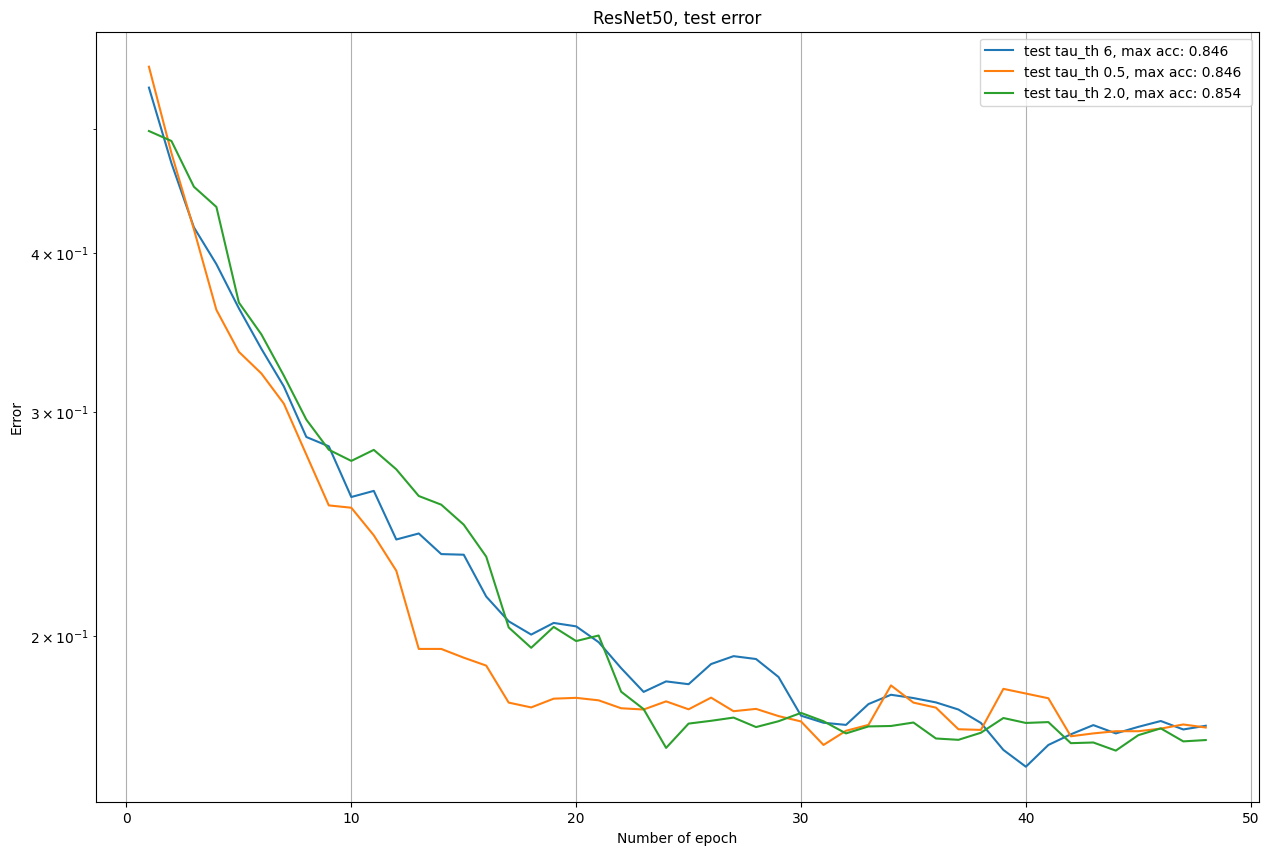

In [10]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, test error')
plt.xlabel('Number of epoch')
plt.ylabel('Error')
for callback in cllbacks:
    suffix = f'tau_th {callback.meta["tau_th"]}'

    acc  = callback.val_acc[0:length]
    min_loss = min(acc)
    acc = smoth(acc,3)
    #y = np.array(callback.val_acc)
    epochs = np.arange(len(acc)) + 1
    #plt.plot(epochs,1- np.array(callback.train_acc), label='Train'+suffix)
    plt.plot(epochs, 1- acc , label=f'test {suffix}, max acc: {max(callback.val_acc):.3f} ' )
plt.yscale("log")
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(callback.train_acc)}, on {np.argmax(callback.train_acc) + 1} epoch')
print(f'Best accuracy on validation: {np.max(callback.val_acc)}, on {np.argmax(callback.val_acc) + 1} epoch')

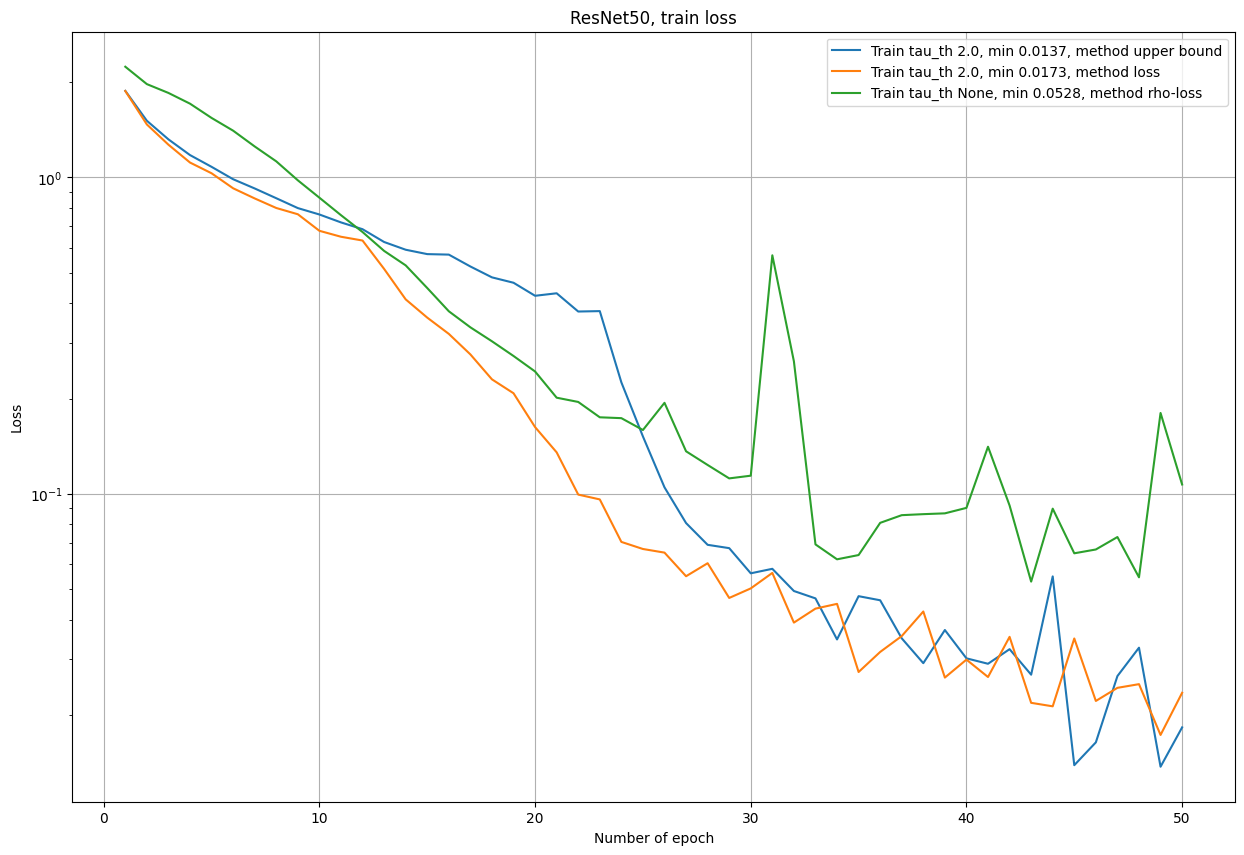

In [19]:
from common_utils import UnCallBack
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
callback_1= UnCallBack.load("callbacks/callback.pickle")
callback_2= UnCallBack.load("callbacks/callback_0.pickle")
callback_3= UnCallBack.load("callbacks/callback_total.pickle")
callback_1.meta["name"] = "upper bound"
callback_2.meta["name"] = "upper bound"
callback_3.meta["name"] = "upper bound"
callback_4= UnCallBack.load("callbacks/loss.pickle")
callback_4.meta["name"] = "loss"
callback_5= UnCallBack.load("callbacks/rho_loss_0.pickle")
callback_5.meta["name"] = "rho-loss"
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')


def smoth(x,N_ = 5):
    return np.convolve([1.0/N_]*N_,x,"valid")

cllbacks = [callback_1, callback_2, callback_3, callback_4, callback_5]
cllbacks =[callback_3, callback_4, callback_5]

length = min( len(i.train_loss) for i in cllbacks)


for idx , callback in enumerate(cllbacks):
    suffix = f'tau_th {callback.meta["tau_th"]}'
    
    min_loss = min(callback.train_loss[0:length])
    y = smoth(callback.train_loss[0:length],1)
    epochs = np.arange(length) + 1
    plt.plot(epochs, y , label=f'Train {suffix}, min {min_loss:.4f}, method {callback.meta["name"]}')

plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

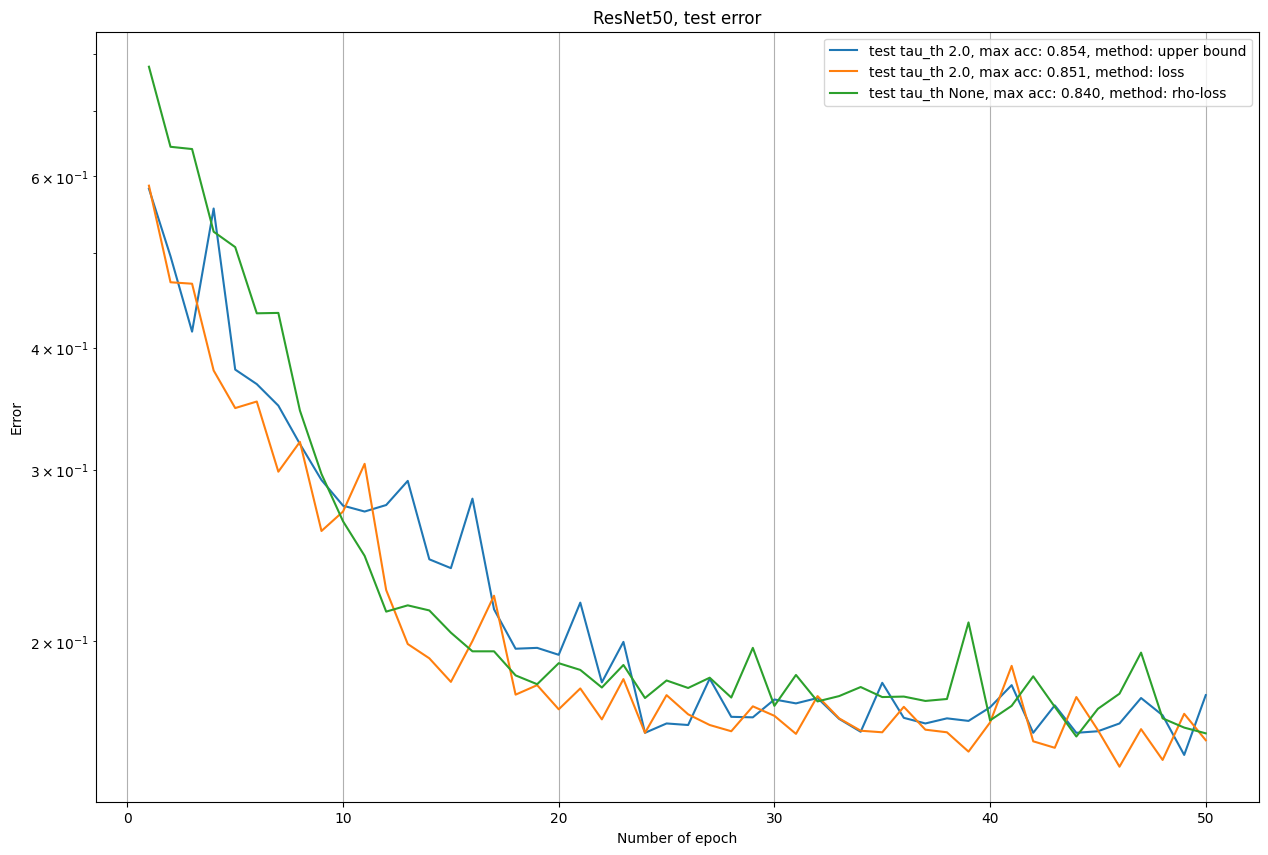

In [12]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, test error')
plt.xlabel('Number of epoch')
plt.ylabel('Error')
for callback in cllbacks:
    suffix = f'tau_th {callback.meta["tau_th"]}'

    acc  = callback.val_acc[0:length]
    min_loss = min(acc)
    acc = smoth(acc,1)
    #y = np.array(callback.val_acc)
    epochs = np.arange(len(acc)) + 1
    #plt.plot(epochs,1- np.array(callback.train_acc), label='Train'+suffix)
    plt.plot(epochs, 1- acc , label=f'test {suffix}, max acc: {max(callback.val_acc):.3f}, method: {callback.meta["name"]}' )
plt.yscale("log")
plt.legend()
plt.grid(True)